### Imports

In [1]:
import pandas as pd
import torch
import numpy as np
import torch
import torch_geometric.datasets as datasets
import torch_geometric.data as data
import torch_geometric.transforms as transforms
import networkx as nx
from torch_geometric.utils.convert import to_networkx
from torch_geometric.data import HeteroData
import torch_geometric.transforms as T
from sklearn.preprocessing import MinMaxScaler
# set max num of rows and cols to display
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

### Read Pre-processed Drug-Side-Effect List 

In [2]:
df_all_se = pd.read_csv('../../prep_data/drug_all_se_pubchem.csv')
df_all_se.head(1)

,STITCH ID STEREO,MEDRA TERM UMLS CONCEPT ID,se_count,cid,mw,mf,polararea,complexity,xlogp,heavycnt,hbonddonor,hbondacc,rotbonds,inchi,isosmiles,canonicalsmiles,inchikey,iupacname,exactmass,monoisotopicmass,charge,covalentunitcnt,isotopeatomcnt,totalatomstereocnt,definedatomstereocnt,undefinedatomstereocnt,totalbondstereocnt,definedbondstereocnt,undefinedbondstereocnt,pclidcnt,gpidcnt,gpfamilycnt,neighbortype,meshheadings,annothits,annothitcnt,aids,cidcdate,sidsrcname,depcatg,annotation
0,CID000000119,"['C0002792', 'C0030193', 'C0151828', 'C0002994...",5,119,103.12,C4H9NO2,63.3,62.7,-3.2,7,2,3,3,"InChI=1S/C4H9NO2/c5-3-1-2-4(6)7/h1-3,5H2,(H,6,7)",C(CC(=O)O)CN,C(CC(=O)O)CN,BTCSSZJGUNDROE-UHFFFAOYSA-N,4-aminobutanoic acid,103.063,103.063,0,1,0,0,0,0,0,0,0,82230,34891,13769,2D+3D,gamma-Aminobutyric Acid,Biological Test Results|Chemical and Physical ...,15,155|157|161|165|167|175|190|248|328|357|410|41...,20040916,001Chemical|3B Scientific (Wuhan) Corp|3WAY PH...,Chemical Vendors|Curation Efforts|Governmental...,"COVID-19, COVID19, Coronavirus, Corona-virus, ..."


In [3]:
df_all_se.columns

Index(['STITCH ID STEREO', 'MEDRA TERM UMLS CONCEPT ID', 'se_count', 'cid',
       'mw', 'mf', 'polararea', 'complexity', 'xlogp', 'heavycnt',
       'hbonddonor', 'hbondacc', 'rotbonds', 'inchi', 'isosmiles',
       'canonicalsmiles', 'inchikey', 'iupacname', 'exactmass',
       'monoisotopicmass', 'charge', 'covalentunitcnt', 'isotopeatomcnt',
       'totalatomstereocnt', 'definedatomstereocnt', 'undefinedatomstereocnt',
       'totalbondstereocnt', 'definedbondstereocnt', 'undefinedbondstereocnt',
       'pclidcnt', 'gpidcnt', 'gpfamilycnt', 'neighbortype', 'meshheadings',
       'annothits', 'annothitcnt', 'aids', 'cidcdate', 'sidsrcname', 'depcatg',
       'annotation'],
      dtype='object')

In [4]:
drug_pub_prop_cols = [ 'mw', 'polararea', 'complexity','heavycnt',
       'hbonddonor', 'hbondacc', 'rotbonds']

In [5]:
df_all_se[drug_pub_prop_cols].isnull().sum()

mw            0
polararea     0
complexity    0
heavycnt      0
hbonddonor    0
hbondacc      0
rotbonds      0
dtype: int64

### Create Transformation Mapping for drug and side-effect

In [6]:
STITCH_TO_ID_DICT = {id: idx for idx, id in enumerate(df_all_se['STITCH ID STEREO'])}
ID_TO_STITCH_DICT = {v: k for k, v in STITCH_TO_ID_DICT.items()}

In [7]:
STITCHID_TO_PUBPPROP_DICT = {idx: _ for idx, (stid, _) in enumerate(zip(df_all_se['STITCH ID STEREO'], df_all_se[drug_pub_prop_cols].values))}


In [8]:
# Create a flattened list of unique meddra term concept id
column_list = df_all_se['MEDRA TERM UMLS CONCEPT ID'].tolist()
unique_values = list(set([item for sublist in column_list for item in eval(sublist)]))
unique_values.sort()
MEDRAID_TO_ID_DICT = {id: idx for idx, id in enumerate(unique_values)}
ID_TO_MEDRAID_DICT = {v: k for k, v in MEDRAID_TO_ID_DICT.items()}

In [9]:
# assert if df stitch id stereo is unique
assert len(df_all_se['STITCH ID STEREO'].unique()) == len(df_all_se['STITCH ID STEREO'])

### Create HeteroData

In [10]:
useMinMaxScaler = True

In [11]:
drug_node_features = torch.stack([torch.tensor(_, dtype=torch.float) for _ in df_all_se[drug_pub_prop_cols].values])
if useMinMaxScaler:
    scaler = MinMaxScaler()
    print("Before", drug_node_features.shape)
    drug_node_features = scaler.fit_transform(drug_node_features)
    print('After MinMax', drug_node_features.shape)
    drug_node_features = torch.tensor(drug_node_features, dtype=torch.float)
print("Final: UseMinMax", useMinMaxScaler, drug_node_features.shape)
# # Create a dictionary of node features
# drug_node_features = torch.tensor(np.zeros((len(df_all_se['STITCH ID STEREO']),881)))
# side_effect_node_features = torch.tensor(np.zeros((len(unique_values),881)))


# print('drug_nodes', drug_node_features.shape)
# print('side_effect_nodes', side_effect_node_features.shape)

Before torch.Size([1326, 7])
After MinMax (1326, 7)
Final: UseMinMax True torch.Size([1326, 7])


In [12]:
# create edge index for drug-side effect from multi-label column_list
edge_index = []
for idx, row in df_all_se.iterrows():
    for se in eval(row['MEDRA TERM UMLS CONCEPT ID']):
        edge_index.append([STITCH_TO_ID_DICT[row['STITCH ID STEREO']], MEDRAID_TO_ID_DICT[se]])
edge_index = torch.tensor(edge_index).T

# print('side_effect_node_features', side_effect_node_features.shape)
print('edge_index', edge_index.shape)
print('edge_index', edge_index)

edge_index torch.Size([2, 129851])
edge_index tensor([[   0,    0,    0,  ..., 1325, 1325, 1325],
        [  31,  657, 1091,  ...,  462, 1221,  835]])


In [13]:
# # sanity check
# df_all_se.head(1)

In [14]:
# STITCH_TO_ID_DICT['CID000000119']

In [15]:
# MEDRAID_TO_ID_DICT['C0151828'], MEDRAID_TO_ID_DICT['C0030193'], MEDRAID_TO_ID_DICT['C0042109'], MEDRAID_TO_ID_DICT['C0002994']

In [16]:
# Create a heterograph with 2 types of nodes: drug and side effect
data = HeteroData()

# Add nodes
data['drug'].node_id = torch.arange(drug_node_features.shape[0])
data['side_effect'].node_id = torch.arange(len(unique_values))

# Add node features
data['drug'].x = drug_node_features

# Add edges
data['drug', 'side_effect'].edge_index = edge_index

print(data)

HeteroData(
  drug={
    node_id=[1326],
    x=[1326, 7]
  },
  side_effect={ node_id=[2061] },
  (drug, to, side_effect)={ edge_index=[2, 129851] }
)


### Hetero Data Viz

In [17]:
# # Full Graph View
# import networkx as nx
# import matplotlib.pyplot as plt
# import torch
# from torch_geometric.data import HeteroData


# # Convert heterograph to NetworkX graph
# graph = nx.Graph()

# # Add nodes to the NetworkX graph with unique IDs for each node type
# drug_nodes = data['drug'].node_id.numpy()
# side_effect_nodes = data['side_effect'].node_id.numpy()

# drug_nodes_unique = [f"drug_{node_id}" for node_id in drug_nodes]
# side_effect_nodes_unique = [f"side_effect_{node_id}" for node_id in side_effect_nodes]

# # Add nodes to the NetworkX graph
# graph.add_nodes_from(drug_nodes_unique, node_type='drug')
# graph.add_nodes_from(side_effect_nodes_unique, node_type='side_effect')

# # Add edges to the NetworkX graph
# drug_edges = data['drug', 'side_effect'].edge_index
# for i in range(drug_edges.shape[1]):
#     source = drug_edges[0, i].item()
#     target = drug_edges[1, i].item()
#     source_id = f"drug_{source}"
#     target_id = f"side_effect_{target}"
#     graph.add_edge(source_id, target_id)

# # Visualize the graph using NetworkX
# pos = nx.spring_layout(graph)  # Compute node positions

# # Separate nodes by type for different visualization colors
# drug_nodes = [n for n, d in graph.nodes(data=True) if d['node_type'] == 'drug']
# side_effect_nodes = [n for n, d in graph.nodes(data=True) if d['node_type'] == 'side_effect']

# # Draw nodes with different colors based on type
# nx.draw_networkx_nodes(graph, pos, nodelist=drug_nodes, node_color='blue', label='Drug Nodes')
# nx.draw_networkx_nodes(graph, pos, nodelist=side_effect_nodes, node_color='red', label='Side Effect Nodes')

# # Draw edges
# nx.draw_networkx_edges(graph, pos)

# # Draw node labels
# node_labels = {n: str(n) for n in graph.nodes()}
# nx.draw_networkx_labels(graph, pos, labels=node_labels)

# # Display the graph
# plt.axis('off')
# plt.legend()
# plt.show()

In [18]:
# # Plot random number of edges and all associated nodes
# import networkx as nx
# import matplotlib.pyplot as plt
# import torch
# import random
# from torch_geometric.data import HeteroData

# # Convert heterograph to NetworkX graph
# graph = nx.Graph()

# # Define the number of random edges you want to visualize
# num_random_edges = 10

# # Randomly select a subset of edges
# random_edge_indices = random.sample(range(data['drug', 'side_effect'].edge_index.shape[1]), num_random_edges)

# # Add nodes to the NetworkX graph with unique IDs for each node type
# drug_nodes = data['drug'].node_id.numpy()
# side_effect_nodes = data['side_effect'].node_id.numpy()

# # sample drug_nodes to have only nodes within random_edge_indices
# drug_nodes = np.unique(data['drug', 'side_effect'].edge_index[0, random_edge_indices].numpy())
# side_effect_nodes = np.unique(data['drug', 'side_effect'].edge_index[1, random_edge_indices].numpy())


# drug_nodes_unique = [f"drug_{node_id}" for node_id in drug_nodes]
# side_effect_nodes_unique = [f"side_effect_{node_id}" for node_id in side_effect_nodes]

# # Add nodes to the NetworkX graph
# graph.add_nodes_from(drug_nodes_unique, node_type='drug')
# graph.add_nodes_from(side_effect_nodes_unique, node_type='side_effect')

# # Add edges to the NetworkX graph
# drug_edges = data['drug', 'side_effect'].edge_index[:, random_edge_indices]
# for i in range(drug_edges.shape[1]):
#     source = drug_edges[0, i].item()
#     target = drug_edges[1, i].item()
#     source_id = f"drug_{source}"
#     target_id = f"side_effect_{target}"
#     graph.add_edge(source_id, target_id)

# # Visualize the graph using NetworkX
# pos = nx.spring_layout(graph)  # Compute node positions

# # Separate nodes by type for different visualization colors
# drug_nodes = [n for n, d in graph.nodes(data=True) if d['node_type'] == 'drug']
# side_effect_nodes = [n for n, d in graph.nodes(data=True) if d['node_type'] == 'side_effect']

# # Draw nodes with different colors based on type
# nx.draw_networkx_nodes(graph, pos, nodelist=drug_nodes, node_color='blue', label='Drug Nodes')
# nx.draw_networkx_nodes(graph, pos, nodelist=side_effect_nodes, node_color='red', label='Side Effect Nodes')

# # Draw edges
# nx.draw_networkx_edges(graph, pos)

# # Draw node labels
# node_labels = {n: str(n) for n in graph.nodes()}
# nx.draw_networkx_labels(graph, pos, labels=node_labels)

# # Display the graph
# plt.axis('off')
# plt.legend()
# plt.show()


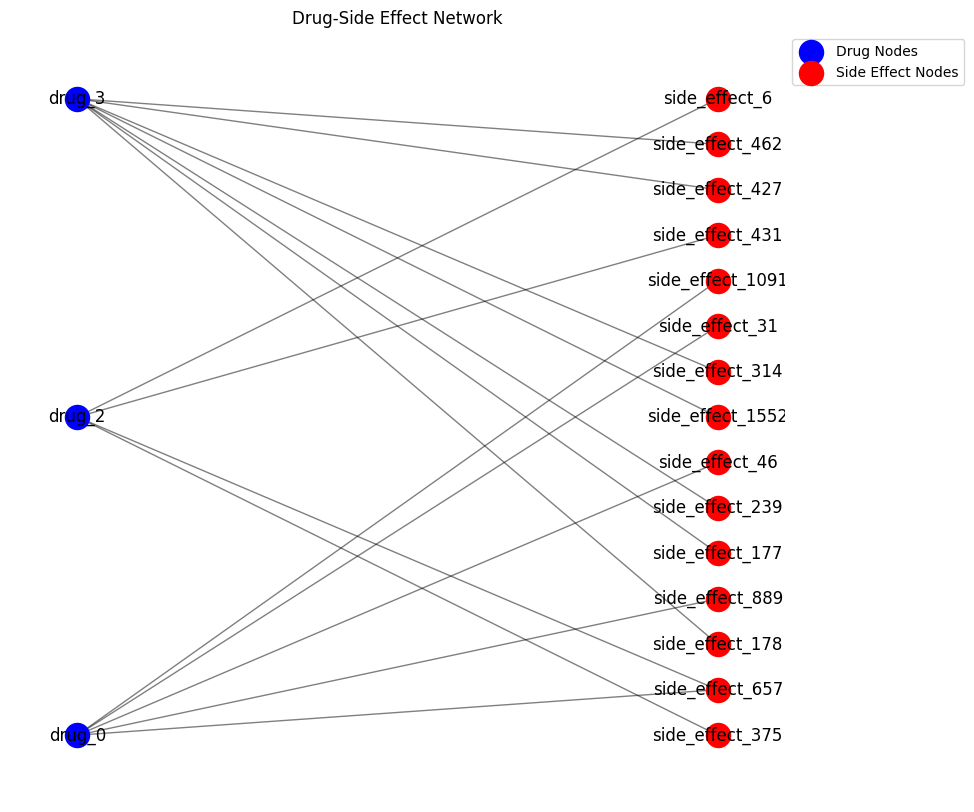

In [19]:
# plot for selected list of drug_id and all associated side effects
import networkx as nx
import matplotlib.pyplot as plt
import torch
import random
from torch_geometric.data import HeteroData, Data

# Convert heterograph to NetworkX graph
graph = nx.Graph()

# list of drug_id to visualize all its associated side effects
drug_id_list = [0, 2, 3]

# associated possible unique side effects using edge_index when drug_id is in drug_id_list
side_effect_nodes = np.unique(data['drug', 'side_effect'].edge_index[1, np.isin(data['drug', 'side_effect'].edge_index[0], drug_id_list)].numpy())

# filter out edges that are between drug_id_list and side_effect_nodes
drug_edges = data['drug', 'side_effect'].edge_index[:, np.isin(data['drug', 'side_effect'].edge_index[0], drug_id_list) & np.isin(data['drug', 'side_effect'].edge_index[1], side_effect_nodes)]

drug_nodes_unique = [f"drug_{node_id}" for node_id in drug_id_list]
side_effect_nodes_unique = [f"side_effect_{node_id}" for node_id in side_effect_nodes]

# Add nodes to the NetworkX graph
graph.add_nodes_from(drug_nodes_unique, node_type='drug')
graph.add_nodes_from(side_effect_nodes_unique, node_type='side_effect')

# Add edges to the NetworkX graph
for i in range(drug_edges.shape[1]):
    source = drug_edges[0, i].item()
    target = drug_edges[1, i].item()
    source_id = f"drug_{source}"
    target_id = f"side_effect_{target}"
    graph.add_edge(source_id, target_id)

# Visualize the graph using NetworkX
# pos = nx.spring_layout(graph, seed=1)  # Compute node positions
pos = nx.bipartite_layout(graph, drug_nodes_unique, align='vertical', scale=5)  # Compute node positions
# Separate nodes by type for different visualization colors
drug_nodes = [n for n, d in graph.nodes(data=True) if d['node_type'] == 'drug']
side_effect_nodes = [n for n, d in graph.nodes(data=True) if d['node_type'] == 'side_effect']

# Draw nodes with different colors based on type
nx.draw_networkx_nodes(graph, pos, nodelist=drug_nodes, node_color='blue', label='Drug Nodes', cmap=plt.cm.Blues)
nx.draw_networkx_nodes(graph, pos, nodelist=side_effect_nodes, node_color='red', label='Side Effect Nodes', cmap=plt.cm.Reds)

# Draw edges with different colors based on type

nx.draw_networkx_edges(graph, pos, edge_color='black', width=1.0, alpha=0.5)

# Draw edges
# nx.draw_networkx_edges(graph, pos)

# Draw node labels
node_labels = {n: str(n) for n in graph.nodes()}
nx.draw_networkx_labels(graph, pos, labels=node_labels)

# Display the graph
plt.axis('off')
# increase figure size
plt.gcf().set_size_inches(10, 10)
# position legend to the right of the graph
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title('Drug-Side Effect Network')
plt.show()


In [20]:
# graph.nodes()
# # link a map to most common drug_name and side_effect_name

### Hetero Link Prediction task

In [21]:
data

HeteroData(
  drug={
    node_id=[1326],
    x=[1326, 7]
  },
  side_effect={ node_id=[2061] },
  (drug, to, side_effect)={ edge_index=[2, 129851] }
)

In [22]:
import torch_geometric.transforms as T
# We also need to make sure to add the reverse edges from movies to users
# in order to let a GNN be able to pass messages in both directions.
# We can leverage the `T.ToUndirected()` transform for this from PyG:
data = T.ToUndirected()(data)

In [23]:
data

HeteroData(
  drug={
    node_id=[1326],
    x=[1326, 7]
  },
  side_effect={ node_id=[2061] },
  (drug, to, side_effect)={ edge_index=[2, 129851] },
  (side_effect, rev_to, drug)={ edge_index=[2, 129851] }
)

### Define Edge level Train Split

In [80]:
# For this, we first split the set of edges into
# training (80%), validation (10%), and testing edges (10%).
# Across the training edges, we use 70% of edges for message passing,
# and 30% of edges for supervision.
# We further want to generate fixed negative edges for evaluation with a ratio of 2:1.
# Negative edges during training will be generated on-the-fly.
# We can leverage the `RandomLinkSplit()` transform for this from PyG:
transform = T.RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    disjoint_train_ratio=0.3,
    neg_sampling_ratio=2.0,
    add_negative_train_samples=False,
    edge_types=('drug', 'to', 'side_effect'),
    rev_edge_types=('side_effect', 'rev_to', 'drug'), 
)


train_data, val_data, test_data = transform(data)
print("Training data:")
print("==============")
print(train_data)
print()
print("Validation data:")
print("================")
print(val_data)

Training data:
HeteroData(
  drug={
    node_id=[1326],
    x=[1326, 7]
  },
  side_effect={ node_id=[2061] },
  (drug, to, side_effect)={
    edge_index=[2, 72717],
    edge_label=[31164],
    edge_label_index=[2, 31164]
  },
  (side_effect, rev_to, drug)={ edge_index=[2, 72717] }
)

Validation data:
HeteroData(
  drug={
    node_id=[1326],
    x=[1326, 7]
  },
  side_effect={ node_id=[2061] },
  (drug, to, side_effect)={
    edge_index=[2, 103881],
    edge_label=[38955],
    edge_label_index=[2, 38955]
  },
  (side_effect, rev_to, drug)={ edge_index=[2, 103881] }
)


### RWR Negative Samples

In [45]:
import pickle, os
dump_loc = '../../prep_data/stitch/negative_samples_rwr.pkl'

with open(dump_loc, 'rb') as f:
    neg_samples_dict = pickle.load(f)

In [46]:
neg_samples_dict_map = {STITCH_TO_ID_DICT[k]: [STITCH_TO_ID_DICT[_] for _ in v] for k, v in neg_samples_dict.items()}

In [47]:
train_data['drug', 'to', 'side_effect'].edge_label

tensor([1., 1., 1.,  ..., 1., 1., 1.])

In [81]:
def add_negative_samples(data, neg_samples_dict_map, ns_ratio=1):
    ### manually add negative edges to train_data
    ## access  (drug, to, side_effect) from train_data
    
    ng_edge_label_index = []
    ng_edge_label = []
    ps_edge_label_index = data['drug', 'to', 'side_effect'].edge_label_index.numpy()

    for idx, (drug_id, se_id) in enumerate(zip(ps_edge_label_index[0], ps_edge_label_index[1])) :
        rng = np.random.default_rng(idx)
        neg_samples = rng.choice(neg_samples_dict_map[drug_id], ns_ratio)
        for neg_sample in neg_samples:
            ng_edge_label_index.append([neg_sample, se_id])
            ng_edge_label.append(0)

    ng_edge_label_index = torch.tensor(ng_edge_label_index).T
    ng_edge_label = torch.tensor(ng_edge_label)
    # print(data)
    # add negative samples to train_data
    ng_combined_edge_label_index = torch.cat([data['drug', 'to', 'side_effect'].edge_label_index, ng_edge_label_index], dim=1)
    ng_combined_edge_label = torch.cat([data['drug', 'to', 'side_effect'].edge_label, ng_edge_label], dim=0)
    # Shuffle the columns (permutations of indices)
    num_columns = ng_combined_edge_label_index.size(1)
    shuffled_indices = torch.randperm(num_columns)
    shuffled_ng_combined_edge_label_index = ng_combined_edge_label_index[:, shuffled_indices]

    # Shuffle the values in ng_combined_edge_label accordingly
    shuffled_ng_combined_edge_label = ng_combined_edge_label[shuffled_indices]
    data['drug', 'to', 'side_effect'].edge_label_index = shuffled_ng_combined_edge_label_index
    data['drug', 'to', 'side_effect'].edge_label = shuffled_ng_combined_edge_label
    

    return data

In [82]:
train_data['drug', 'to', 'side_effect'].edge_index

tensor([[ 742,  250,  139,  ...,  742,   82,  807],
        [ 452,   29, 1299,  ...,   75,    2,  646]])

In [83]:
train_data_ng  = add_negative_samples(train_data, neg_samples_dict_map, ns_ratio=10)

In [84]:
# val_data = add_negative_samples(val_data, neg_samples_dict_map, ns_ratio=2)

### Define Mini-batch Loader

In [85]:
# !pip install pyg-lib -f https://data.pyg.org/whl/torch-1.12.1+cu117.html

In [86]:
num_neighbors=[15, 10]
batch_size = 128

In [87]:
# In the first hop, we sample at most 20 neighbors.
# In the second hop, we sample at most 10 neighbors.
# In addition, during training, we want to sample negative edges on-the-fly with
# a ratio of 2:1.
# We can make use of the `loader.LinkNeighborLoader` from PyG:
from torch_geometric.loader.link_neighbor_loader import LinkNeighborLoader

# Define seed edges:
edge_label_index = train_data["drug", "to", "side_effect"].edge_label_index
edge_label = train_data["drug", "to", "side_effect"].edge_label

train_loader = LinkNeighborLoader(
    data=train_data,
    num_neighbors=num_neighbors,
    # neg_sampling_ratio=2.0,
    edge_label_index=(("drug", "to", "side_effect"), edge_label_index),
    edge_label=edge_label,
    batch_size=batch_size,
    shuffle=True
)

# Inspect a sample:
sampled_data = next(iter(train_loader))

print("Sampled mini-batch:")
print("===================")
print(sampled_data)


Sampled mini-batch:
HeteroData(
  drug={
    node_id=[1116],
    x=[1116, 7],
    n_id=[1116]
  },
  side_effect={
    node_id=[1283],
    n_id=[1283]
  },
  (drug, to, side_effect)={
    edge_index=[2, 5978],
    edge_label=[128],
    edge_label_index=[2, 128],
    e_id=[5978],
    input_id=[128]
  },
  (side_effect, rev_to, drug)={
    edge_index=[2, 8175],
    e_id=[8175]
  }
)


### Creating a Hetero Link-level GNN

In [88]:
from torch_geometric.nn import SAGEConv, to_hetero
import torch.nn.functional as F
from torch import Tensor


class GNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()

        self.conv1 = SAGEConv(hidden_channels, hidden_channels)
        self.lin1 = torch.nn.Linear(hidden_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.lin2 = torch.nn.Linear(hidden_channels, hidden_channels)
        
    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
        x = F.elu(self.conv1(x, edge_index)+self.lin1(x))
        x = self.conv2(x, edge_index) + self.lin2(x)
        return x

In [89]:
# Our final classifier applies the dot-product between source and destination
# node embeddings to derive edge-level predictions:
class Classifier(torch.nn.Module):
    def forward(self, x_user: Tensor, x_movie: Tensor, edge_label_index: Tensor) -> Tensor:
        # Convert node embeddings to edge-level representations:
        edge_feat_user = x_user[edge_label_index[0]]
        edge_feat_movie = x_movie[edge_label_index[1]]

        # Apply dot-product to get a prediction per supervision edge:
        return (edge_feat_user * edge_feat_movie).sum(dim=-1)

In [90]:
# Homegenous Model for Edge Prediction
class Model(torch.nn.Module):
    def __init__(self, hidden_channels, use_node_features=False):
        super().__init__()
        # Instantiate node embeddings:
        self.drug_emb = torch.nn.Embedding(data["drug"].num_nodes, hidden_channels)
        self.seff_emb = torch.nn.Embedding(data["side_effect"].num_nodes, hidden_channels)
        # Instantiate GNNs:
        self.gnn = GNN(hidden_channels)
        # Convert GNN model into a heterogeneous variant:
        self.gnn = to_hetero(self.gnn, metadata=data.metadata())
        self.use_node_features = use_node_features
        if use_node_features:
            self.drug_feat_layernorm = torch.nn.LayerNorm(data["drug"].num_features)
            self.drug_lin = torch.nn.Linear(data["drug"].num_features, hidden_channels)
        # Instantiate classifier:
        self.classifier = Classifier() 

    def forward(self, data: HeteroData) -> Tensor:
        if self.use_node_features:
            x_dict = {
                "drug":  self.drug_emb(data["drug"].node_id) + self.drug_lin(self.drug_feat_layernorm(data["drug"].x)),
                "side_effect": self.seff_emb(data["side_effect"].node_id)
            }
        else:
            # layer normalization of input features:
            x_dict = {
                "drug":  self.drug_emb(data["drug"].node_id), #+ self.drug_lin(self.drug_feat_layernorm(data["drug"].x)),
                "side_effect": self.seff_emb(data["side_effect"].node_id)
            }

        # `x_dict` holds feature matrices of all node types
        # `edge_index_dict` holds all edge indices of all edge types
        x_dict = self.gnn(x_dict, data.edge_index_dict)
        pred = self.classifier(
            x_dict["drug"],
            x_dict["side_effect"],
            data["drug", "to", "side_effect"].edge_label_index,
        )

        return pred
        
model = Model(hidden_channels=256)
model

Model(
  (drug_emb): Embedding(1326, 256)
  (seff_emb): Embedding(2061, 256)
  (gnn): GraphModule(
    (conv1): ModuleDict(
      (drug__to__side_effect): SAGEConv(256, 256, aggr=mean)
      (side_effect__rev_to__drug): SAGEConv(256, 256, aggr=mean)
    )
    (lin1): ModuleDict(
      (drug): Linear(in_features=256, out_features=256, bias=True)
      (side_effect): Linear(in_features=256, out_features=256, bias=True)
    )
    (conv2): ModuleDict(
      (drug__to__side_effect): SAGEConv(256, 256, aggr=mean)
      (side_effect__rev_to__drug): SAGEConv(256, 256, aggr=mean)
    )
    (lin2): ModuleDict(
      (drug): Linear(in_features=256, out_features=256, bias=True)
      (side_effect): Linear(in_features=256, out_features=256, bias=True)
    )
  )
  (classifier): Classifier()
)

### Train the hetero model

In [91]:
import tqdm
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: '{device}'")

model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(1, 5):
    total_loss = total_examples = 0
    for sampled_data in tqdm.tqdm(train_loader):
        optimizer.zero_grad()

        sampled_data.to(device)
        pred = model(sampled_data)

        ground_truth = sampled_data["drug", "to", "side_effect"].edge_label
        loss = F.binary_cross_entropy_with_logits(pred, ground_truth)

        loss.backward()
        optimizer.step()
        total_loss += float(loss) * pred.numel()
        total_examples += pred.numel()
    print(f"Epoch: {epoch:03d}, Loss: {total_loss / total_examples:.4f}")

Device: 'cuda'


 14%|█▍        | 372/2679 [00:06<00:38, 60.13it/s]


KeyboardInterrupt: 

In [92]:
# Define the validation seed edges:
edge_label_index = val_data["drug", "to", "side_effect"].edge_label_index
edge_label = val_data["drug", "to", "side_effect"].edge_label

val_loader = LinkNeighborLoader(
    data=val_data,
    num_neighbors=num_neighbors,
    edge_label_index=(("drug", "to", "side_effect"), edge_label_index),
    edge_label=edge_label,
    batch_size=batch_size,
    shuffle=False,
)

sampled_data = next(iter(val_loader))

print("Sampled mini-batch:")
print("===================")
print(sampled_data)


Sampled mini-batch:
HeteroData(
  drug={
    node_id=[1124],
    x=[1124, 7],
    n_id=[1124]
  },
  side_effect={
    node_id=[1304],
    n_id=[1304]
  },
  (drug, to, side_effect)={
    edge_index=[2, 7563],
    edge_label=[128],
    edge_label_index=[2, 128],
    e_id=[7563],
    input_id=[128]
  },
  (side_effect, rev_to, drug)={
    edge_index=[2, 8259],
    e_id=[8259]
  }
)


In [41]:
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score

preds = []
ground_truths = []
for sampled_data in tqdm.tqdm(val_loader):
    with torch.no_grad():
        sampled_data.to(device)
        pred = model(sampled_data)
        # Applying sigmoid activation function to the predicted values
        output_probs = torch.sigmoid(pred)

        # Converting probabilities to binary class predictions
        output_classes = (output_probs > 0.5).int()
        preds.append(output_classes)
        ground_truths.append(sampled_data["drug", "to", "side_effect"].edge_label)

pred = torch.cat(preds, dim=0).cpu().numpy()
ground_truth = torch.cat(ground_truths, dim=0).cpu().numpy()

auc = roc_auc_score(ground_truth, pred)
ap = average_precision_score(ground_truth, pred)
f1 = f1_score(ground_truth, pred)
acc = (pred == ground_truth).mean()

print()
print(f"Validation AUC: {auc:.4f}")
print(f"Validation AP: {ap:.4f}")
print(f"Validation F1: {f1:.4f}")
print(f"Validation Accuracy: {acc:.4f}")

  0%|          | 0/102 [00:00<?, ?it/s]

100%|██████████| 102/102 [00:01<00:00, 52.85it/s]


Validation AUC: 0.7578
Validation AP: 0.5847
Validation F1: 0.6778
Validation Accuracy: 0.7998


### Method Train and Val

In [93]:
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, precision_score, recall_score

@torch.no_grad()
def compute_metrics(model, val_loader, debug=False):
    model.eval()
    preds = []
    ground_truths = []
    total_examples = total_loss = 0
    for sampled_data in tqdm.tqdm(val_loader):
        with torch.no_grad():
            sampled_data.to(device)
            pred = model(sampled_data)
            ground_truth = sampled_data["drug", "to", "side_effect"].edge_label
            loss = F.binary_cross_entropy_with_logits(pred, ground_truth)
            total_loss += float(loss) * pred.numel()
            total_examples += pred.numel()
            # Applying sigmoid activation function to the predicted values
            output_probs = torch.sigmoid(pred)

            # Converting probabilities to binary class predictions
            output_classes = (output_probs > 0.5).int()
            preds.append(output_classes)
            ground_truths.append(ground_truth)

    pred = torch.cat(preds, dim=0).cpu().numpy()
    ground_truth = torch.cat(ground_truths, dim=0).cpu().numpy()

    auc = roc_auc_score(ground_truth, pred)
    ap = average_precision_score(ground_truth, pred)
    f1 = f1_score(ground_truth, pred)
    acc = (pred == ground_truth).mean()
    loss = total_loss / total_examples
    # compute precission, recall, f1, accuracy
    precission = average_precision_score(ground_truth, pred)
    recall = recall_score(ground_truth, pred)


    if debug:
        print()
        print(f"Validation AUC: {auc:.4f}")
        print(f"Validation AP: {ap:.4f}")
        print(f"Validation F1: {f1:.4f}")
        print(f"Validation Accuracy: {acc:.4f}")
        print(f"Validation precission: {precission:.4f}")
        print(f"Validation recall: {recall:.4f}")
    return loss, auc, ap, f1, acc

In [94]:
def train(model, train_loader, optimizer, device):
    model.train()
    total_loss = total_examples = 0
    for data in tqdm.tqdm(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        ground_truth = data["drug", "to", "side_effect"].edge_label
        loss = F.binary_cross_entropy_with_logits(out, ground_truth)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * out.numel()
        total_examples += out.numel()
    return total_loss / total_examples

In [95]:
def main(model, train_loader, val_loader, test_loader, device, epochs, name):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", factor=0.5, patience=5
    )
    best_val_f1 = 0
    best_epoch = 0
    for epoch in range(1, epochs + 1):
        loss = train(model, train_loader, optimizer, device)
        _, train_auc, train_ap, train_f1, train_acc = compute_metrics(model, train_loader)
        # val_loss = test(model, val_loader, device)
        val_loss, val_auc, val_ap, val_f1, val_acc = compute_metrics(model, val_loader)
        print(f"Epoch: {epoch:03d}, Loss: {loss:.4f}, Val Loss: {val_loss:.4f}\n,\
              Train AUC: {train_auc:.4f}, Train AP: {train_ap:.4f}, Train F1: {train_f1:.4f}, Train Acc: {train_acc:.4f}\n,\
              Val AUC: {val_auc:.4f}, Val AP: {val_ap:.4f}, Val F1: {val_f1:.4f}, Val Acc: {val_acc:.4f}")
       
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_epoch = epoch
            torch.save(model.state_dict(), f"{name}.pt")
        scheduler.step(val_f1)
    
    model.load_state_dict(torch.load(f"{name}.pt"))
    return model, best_epoch

In [96]:
# Define seed edges:
test_edge_label_index = test_data["drug", "to", "side_effect"].edge_label_index
test_edge_label = test_data["drug", "to", "side_effect"].edge_label

test_loader = LinkNeighborLoader(
    data=test_data,
    num_neighbors=num_neighbors,
    edge_label_index=(("drug", "to", "side_effect"), test_edge_label_index),
    edge_label=test_edge_label,
    batch_size=batch_size,
    shuffle=False,
)

In [97]:
import tqdm

model = Model(hidden_channels=128, use_node_features=True)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: '{device}'")

model = model.to(device)

main(model, train_loader, val_loader, test_loader, device, epochs=20, name="bihetero_gcn_128_ng")

Device: 'cuda'


  0%|          | 0/2679 [00:00<?, ?it/s]

100%|██████████| 305/305 [00:01<00:00, 182.36it/s]


Epoch: 001, Loss: 0.1946, Val Loss: 2.2473
,              Train AUC: 0.8691, Train AP: 0.7290, Train F1: 0.8336, Train Acc: 0.9731
,              Val AUC: 0.5976, Val AP: 0.3860, Val F1: 0.5227, Val Acc: 0.5510


100%|██████████| 305/305 [00:01<00:00, 161.46it/s]


Epoch: 002, Loss: 0.1219, Val Loss: 2.6267
,              Train AUC: 0.8763, Train AP: 0.7405, Train F1: 0.8421, Train Acc: 0.9742
,              Val AUC: 0.5924, Val AP: 0.3824, Val F1: 0.5217, Val Acc: 0.5377


 14%|█▍        | 373/2679 [00:05<00:33, 68.18it/s]


KeyboardInterrupt: 

In [85]:
compute_metrics(model, test_loader, debug=True)

100%|██████████| 153/153 [00:01<00:00, 152.15it/s]


Validation AUC: 0.7773
Validation AP: 0.6204
Validation F1: 0.7064
Validation Accuracy: 0.8204
Validation precission: 0.6204
Validation recall: 0.6479


(0.41528839774438403,
 0.7773007316134001,
 0.620392648586629,
 0.7063515385584147,
 0.8204338339109228)

In [86]:
model = Model(hidden_channels=128, use_node_features=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: '{device}'")

model = model.to(device)

main(model, train_loader, val_loader, test_loader, device, epochs=20, name="bihetero_nfeat_gcn_128")

Device: 'cuda'


  0%|          | 0/122 [00:00<?, ?it/s]

100%|██████████| 153/153 [00:00<00:00, 214.35it/s]


Epoch: 001, Loss: 0.7671, Val Loss: 0.5308
,              Train AUC: 0.7099, Train AP: 0.5253, Train F1: 0.6071, Train Acc: 0.7650
,              Val AUC: 0.6912, Val AP: 0.5077, Val F1: 0.5758, Val Acc: 0.7558


100%|██████████| 153/153 [00:00<00:00, 228.60it/s]


Epoch: 002, Loss: 0.4740, Val Loss: 0.4510
,              Train AUC: 0.7818, Train AP: 0.5966, Train F1: 0.7086, Train Acc: 0.8035
,              Val AUC: 0.7603, Val AP: 0.5774, Val F1: 0.6809, Val Acc: 0.7938


100%|██████████| 153/153 [00:00<00:00, 190.62it/s]


Epoch: 003, Loss: 0.4296, Val Loss: 0.4428
,              Train AUC: 0.7722, Train AP: 0.6087, Train F1: 0.6986, Train Acc: 0.8138
,              Val AUC: 0.7468, Val AP: 0.5873, Val F1: 0.6618, Val Acc: 0.8027


100%|██████████| 153/153 [00:01<00:00, 101.16it/s]


Epoch: 004, Loss: 0.4072, Val Loss: 0.4331
,              Train AUC: 0.7828, Train AP: 0.6226, Train F1: 0.7135, Train Acc: 0.8215
,              Val AUC: 0.7560, Val AP: 0.6004, Val F1: 0.6758, Val Acc: 0.8098


100%|██████████| 153/153 [00:00<00:00, 217.40it/s]


Epoch: 005, Loss: 0.3921, Val Loss: 0.4134
,              Train AUC: 0.8300, Train AP: 0.6539, Train F1: 0.7676, Train Acc: 0.8363
,              Val AUC: 0.7946, Val AP: 0.6209, Val F1: 0.7266, Val Acc: 0.8191


100%|██████████| 153/153 [00:00<00:00, 220.30it/s]


Epoch: 006, Loss: 0.3831, Val Loss: 0.4268
,              Train AUC: 0.8166, Train AP: 0.6548, Train F1: 0.7561, Train Acc: 0.8386
,              Val AUC: 0.7702, Val AP: 0.6090, Val F1: 0.6961, Val Acc: 0.8141


100%|██████████| 153/153 [00:00<00:00, 216.62it/s]


Epoch: 007, Loss: 0.3765, Val Loss: 0.4171
,              Train AUC: 0.8223, Train AP: 0.6618, Train F1: 0.7632, Train Acc: 0.8424
,              Val AUC: 0.7804, Val AP: 0.6246, Val F1: 0.7108, Val Acc: 0.8227


100%|██████████| 153/153 [00:00<00:00, 228.26it/s]


Epoch: 008, Loss: 0.3359, Val Loss: 0.4027
,              Train AUC: 0.8370, Train AP: 0.6892, Train F1: 0.7839, Train Acc: 0.8574
,              Val AUC: 0.7799, Val AP: 0.6333, Val F1: 0.7112, Val Acc: 0.8273


100%|██████████| 153/153 [00:00<00:00, 227.61it/s]


Epoch: 009, Loss: 0.3250, Val Loss: 0.4093
,              Train AUC: 0.8442, Train AP: 0.6991, Train F1: 0.7929, Train Acc: 0.8627
,              Val AUC: 0.7771, Val AP: 0.6293, Val F1: 0.7070, Val Acc: 0.8252


100%|██████████| 153/153 [00:00<00:00, 240.57it/s]


Epoch: 010, Loss: 0.3184, Val Loss: 0.4042
,              Train AUC: 0.8600, Train AP: 0.7047, Train F1: 0.8070, Train Acc: 0.8655
,              Val AUC: 0.7938, Val AP: 0.6377, Val F1: 0.7287, Val Acc: 0.8297


100%|██████████| 153/153 [00:00<00:00, 232.94it/s]


Epoch: 011, Loss: 0.3172, Val Loss: 0.4235
,              Train AUC: 0.8491, Train AP: 0.7010, Train F1: 0.7975, Train Acc: 0.8637
,              Val AUC: 0.7788, Val AP: 0.6292, Val F1: 0.7092, Val Acc: 0.8252


100%|██████████| 153/153 [00:00<00:00, 235.70it/s]


Epoch: 012, Loss: 0.3124, Val Loss: 0.4132
,              Train AUC: 0.8687, Train AP: 0.7192, Train F1: 0.8183, Train Acc: 0.8735
,              Val AUC: 0.7885, Val AP: 0.6327, Val F1: 0.7218, Val Acc: 0.8270


100%|██████████| 153/153 [00:01<00:00, 121.67it/s]


Epoch: 013, Loss: 0.3100, Val Loss: 0.4266
,              Train AUC: 0.8630, Train AP: 0.7195, Train F1: 0.8143, Train Acc: 0.8736
,              Val AUC: 0.7784, Val AP: 0.6280, Val F1: 0.7086, Val Acc: 0.8246


100%|██████████| 153/153 [00:00<00:00, 228.39it/s]


Epoch: 014, Loss: 0.2901, Val Loss: 0.4164
,              Train AUC: 0.8745, Train AP: 0.7355, Train F1: 0.8280, Train Acc: 0.8820
,              Val AUC: 0.7834, Val AP: 0.6371, Val F1: 0.7161, Val Acc: 0.8293


100%|██████████| 153/153 [00:01<00:00, 92.51it/s]


Epoch: 015, Loss: 0.2824, Val Loss: 0.4192
,              Train AUC: 0.8770, Train AP: 0.7407, Train F1: 0.8315, Train Acc: 0.8847
,              Val AUC: 0.7823, Val AP: 0.6385, Val F1: 0.7149, Val Acc: 0.8300


100%|██████████| 153/153 [00:01<00:00, 100.28it/s]


Epoch: 016, Loss: 0.2782, Val Loss: 0.4390
,              Train AUC: 0.8688, Train AP: 0.7362, Train F1: 0.8242, Train Acc: 0.8821
,              Val AUC: 0.7697, Val AP: 0.6280, Val F1: 0.6968, Val Acc: 0.8242


100%|██████████| 153/153 [00:00<00:00, 217.19it/s]


Epoch: 017, Loss: 0.2761, Val Loss: 0.4225
,              Train AUC: 0.8862, Train AP: 0.7508, Train F1: 0.8414, Train Acc: 0.8901
,              Val AUC: 0.7833, Val AP: 0.6382, Val F1: 0.7161, Val Acc: 0.8299


100%|██████████| 153/153 [00:00<00:00, 197.69it/s]


Epoch: 018, Loss: 0.2724, Val Loss: 0.4250
,              Train AUC: 0.8893, Train AP: 0.7542, Train F1: 0.8447, Train Acc: 0.8919
,              Val AUC: 0.7829, Val AP: 0.6370, Val F1: 0.7154, Val Acc: 0.8293


100%|██████████| 153/153 [00:00<00:00, 158.48it/s]


Epoch: 019, Loss: 0.2697, Val Loss: 0.4584
,              Train AUC: 0.8719, Train AP: 0.7443, Train F1: 0.8291, Train Acc: 0.8860
,              Val AUC: 0.7574, Val AP: 0.6166, Val F1: 0.6782, Val Acc: 0.8180


100%|██████████| 153/153 [00:00<00:00, 196.09it/s]


Epoch: 020, Loss: 0.2601, Val Loss: 0.4363
,              Train AUC: 0.8923, Train AP: 0.7624, Train F1: 0.8496, Train Acc: 0.8960
,              Val AUC: 0.7760, Val AP: 0.6323, Val F1: 0.7059, Val Acc: 0.8266


(Model(
   (drug_emb): Embedding(1326, 128)
   (seff_emb): Embedding(2061, 128)
   (gnn): GraphModule(
     (conv1): ModuleDict(
       (drug__to__side_effect): SAGEConv(128, 128, aggr=mean)
       (side_effect__rev_to__drug): SAGEConv(128, 128, aggr=mean)
     )
     (lin1): ModuleDict(
       (drug): Linear(in_features=128, out_features=128, bias=True)
       (side_effect): Linear(in_features=128, out_features=128, bias=True)
     )
     (conv2): ModuleDict(
       (drug__to__side_effect): SAGEConv(128, 128, aggr=mean)
       (side_effect__rev_to__drug): SAGEConv(128, 128, aggr=mean)
     )
     (lin2): ModuleDict(
       (drug): Linear(in_features=128, out_features=128, bias=True)
       (side_effect): Linear(in_features=128, out_features=128, bias=True)
     )
   )
   (drug_feat_layernorm): LayerNorm((7,), eps=1e-05, elementwise_affine=True)
   (drug_lin): Linear(in_features=7, out_features=128, bias=True)
   (classifier): Classifier()
 ),
 10)

In [67]:
compute_metrics(model, test_loader, debug=True)

100%|██████████| 102/102 [00:02<00:00, 37.73it/s]


Validation AUC: 0.8034
Validation AP: 0.6425
Validation F1: 0.7401
Validation Accuracy: 0.8321
Validation precission: 0.6425
Validation recall: 0.7173


(0.39617568284537086,
 0.8033692722371969,
 0.6425201916692382,
 0.7400874056416369,
 0.8320626363753049)

In [87]:
compute_metrics(model, test_loader, debug=True)

100%|██████████| 153/153 [00:01<00:00, 139.40it/s]


Validation AUC: 0.7896
Validation AP: 0.6335
Validation F1: 0.7231
Validation Accuracy: 0.8275
Validation precission: 0.6335
Validation recall: 0.6759


(0.4104251137044185,
 0.7895841355410089,
 0.6335022093467297,
 0.7231307929969104,
 0.8274675908099088)